# Single-cell Analysis of HCA data with Scanpy
In this Jupyter Notebook, we explore how to import HCA data into your Cloud Environment and perform single-cell analysis (filtering, clustering, and differential gene expression) using [Scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/index.html), a python suite of tools for bioinformatic analysis.

The tutorial is based off Scanpy's tutorial "[Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)". 

It uses subsampled human liver data from the HCA project "[Dissecting the human liver cellular landscape by single cell RNA-seq reveals novel intrahepatic monocyte/ macrophage populations](https://dev.singlecell.gi.ucsc.edu/explore/projects)".

Learn more about the data in the [Single cell RNA sequencing of human liver reveals distinct intrahepatic macrophage populations](https://www.nature.com/articles/s41467-018-06318-7) (MacParland et al., 2018).

Overall, this Notebook provides step-by-step instructions for:

- Importing and exploring files
- Filtering and visualizing cells based on QC metrics
- Normalizing single-cell data
- Identifying highly variable features (feature selection)
- Scaling and performing linear dimensional reduction
- Performing non-linear dimensional reduction
- Clustering cells
- Performing differential expression analysis

DISCLAIMER: 

This Notebook is designed to showcase Jupyter Notebook analysis of HCA data in Terra rather than teach single-cell analysis. The Scanpy tutorial has been modified to exclude some detailed information related to the highlighted Scanpy tools and analysis. To learn more about the features highlighted here, we encourage you to review the original [Scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

## Notebook set-up

### Setting the Cloud Environment
This Notebook uses the Terra R/Bioconductor base image (Python 3.7.9, R4.0.3) with 4 CPUs, which you can select from the Cloud Environment widget at the top right of the Workspace. 

### Running the Notebook
Prior to starting the Notebook, we recommend restarting and clearing the kernel to remove outputs that were previously generated. This will help you understand what each code block is doing as the code the is running.

You can run the code blocks in this tutorial all at one time, or one-by-one. If you run each code block individually, make sure to run each code block in sequential order.

#### Running all cells at one time

To run all, select the "Cell" drop-down at the top of the Notebook and choose "Run All".

#### Running each cell individually

You can run each cell individually in one of the following ways:

- Clicking the `Run` icon at the top of the Notebook
- Using the keyboard shortcut shift return

## Installing environment variables

This Notebook installs several environment variables which allow you to access and manipulate Terra featues like the workspace name, Google bucket, and Google Billing project. We'll use these environment variables at the end of move our data to our workspace Google bucket.

In [1]:
import os

BILLING_PROJECT_ID = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE = os.environ['WORKSPACE_NAME']
bucket = os.environ['WORKSPACE_BUCKET']

## Installing Notebook packages
The code below installs multiple python packages that are useful for single-cell analysis and additionally installs the terra-notebooks-utils API for manipulating HCA data (or any data) that has DRS URIs (see note below).

**What is the terra-notebook-utils API?**

HCA data files are stored in the cloud. Each file is given a GA4GH-compliant DRS URI, a cloud agnostic identifier that allows you to pull files from disparate data repositories.

To access files that have DRS URIs and move them into the Cloud Enviornment, this Notebook uses the DRS client API provided by the terra-notebook-utils Python package. 

You can learn more about this package in the BioData Catalyst Collection DRS URI Notebook [Accessing GA4GH DRS URI data using TNU in Python](https://app.terra.bio/#workspaces/biodata-catalyst/BioData%20Catalyst%20Collection/notebooks/launch/Accessing%20GA4GH%20DRS%20URI%20data%20using%20TNU%20in%20Python.ipynb). 

The terra-notebook-utils is stored in a GitHub repository: https://github.com/DataBiosphere/terra-notebook-utils.

In [2]:
# Install latest terra-notebooks-utils
%pip install --upgrade --no-cache-dir terra-notebook-utils

     |████████████████████████████████| 88 kB 8.5 MB/s eta 0:00:011
     |████████████████████████████████| 53 kB 19.8 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 8.3 MB/s  eta 0:00:01
     |████████████████████████████████| 98 kB 16.6 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 27.8 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 17.0 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 13.6 MB/s eta 0:00:01
     |████████████████████████████████| 784 kB 14.7 MB/s eta 0:00:01
     |████████████████████████████████| 93 kB 20.4 MB/s eta 0:00:01
     |████████████████████████████████| 198 kB 21.4 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 24.1 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 34.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 31.8 MB/s eta 0:00:01
     |████████████████████████████████| 40

In [3]:
#Install packges
!pip install "pandas" "numpy" "scanpy" "loompy"

     |████████████████████████████████| 9.9 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 55.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 41 kB 143 kB/s  eta 0:00:01
     |████████████████████████████████| 4.1 MB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 51.4 MB/s eta 0:00:01
     |████████████████████████████████| 784 kB 56.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 45.7 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.3 MB/s  eta 0:00:01
     |████████████████████████████████| 109 kB 64.2 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 510 kB 59.3 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 63.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 57.8 MB/s eta 0:00:01
     |████████████████████████████

You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [4]:
# Import python packages
import numpy as np
import pandas as pd
import scanpy as sc
import loompy 

## Using terra-notebook-utils to explore HCA files¶
The following code can be used import the terra_notebook_utils.drs API. First, we use the import function to bring in the python package.

In [5]:
# Import terra-notebook-utils DRS URI module
from terra_notebook_utils import drs

You can use the `drs.info()` function to examine a file that has a DRS URI. 

In this example, we're examining an HCA project-level matrix file with the filename `sc-landscape-human-liver-10XV2.loom`.

The output of this function will be infomation about the file name, size, and the Google bucket URL.

In [6]:
drs.info("drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c")

2021-04-30 05:48:39::INFO  Resolving DRS uri 'drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c' through 'https://us-central1-broad-dsde-prod.cloudfunctions.net/martha_v3'.


{'name': 'sc-landscape-human-liver-10XV2.loom',
 'size': 1176122907,
 'updated': '2021-02-19T19:31:35.668Z',
 'url': 'gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom'}

## Copying HCA data into the Cloud Environment
HCA data is hosted in a Google bucket in the cloud. We can use two techniques to import the data into the Cloud Envionment virtual machine we are using to run this Notebook:

1. Using the terra-data-util API to manipulate files with DRS URIs
2. Using Google's gsutil suite of tools for files stored in Google Buckets


DRS URIs allow data to be pulled from multiple sources (Google buckets, Amazon Web Services, Azure, etcl.). If you're using data from different repositories, the terra-data-util API can help pull data regardless which repository the data is in.

HCA data, however, is stored in a Google bucket, which means we can also copy it into our virtual machine using Google's suite of tools for manipulating cloud data, [gsutil]( https://cloud.google.com/storage/docs/gsutil).

Both techniques, shown using the code below, will automatically import the file into our Cloud Environment's [persistent disk file location](https://support.terra.bio/hc/en-us/articles/360047318551).

### Copying HCA data using terra-data-util API
When you import HCA data into a Terra workspace, you'll find the data file DRS URI in the `participant` data table which is automatically created when you import data. 

This tutorial uses a project matrix (Loom file) DRS URI, which you can find in the data table's `__loom__file_drs_uri` column. If you click on the DRS URI link, you'll see the Google bucket location as well.

Once you've identified DRS URI of interest, you can use the function below to copy the data file into your Cloud Envrionment.

For this tutorial, we'll use same DRS URI as above for the sc-landscape-human-liver-10XV2 matrix.

In [7]:
# Copy file with DRS URI into Cloud Envrionemnt
drs.copy('drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c', '.')

2021-04-30 05:48:39::INFO  Enabling requester pays for your workspace. This will only take a few seconds...
2021-04-30 05:48:51::WARNING  Failed to init requester pays for workspace featured-workspaces-hca/Intro-to-HCA-data-on-Terra-dev-trial-can-delete.
2021-04-30 05:48:51::WARNING  You will not be able to access drs urls that interact with requester pays buckets.
2021-04-30 05:48:51::INFO  Resolving DRS uri 'drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c' through 'https://us-central1-broad-dsde-prod.cloudfunctions.net/martha_v3'.
2021-04-30 05:48:52::INFO  Downloading drs://jade-terra.datarepo-prod.broadinstitute.org/v1_4c9d9b2d-a469-40bc-b79b-c3465c154675_57130684-c89c-4b27-9030-298f50cbc95c to /home/jupyter-user/notebooks/Intro-to-HCA-data-on-Terra-dev-trial-can-delete/edit/sc-landscape-human-liver-10XV2.loom


### Copying HCA data using gsutil
If data is located in a Google bucket, another way to import it is to use gsutil.

When you click on the DRS URI link of an HCA data file listed in the `__loom__file_drs_uri` column of the `participant` data table, you'll notice a new window with a gsutil command for copying the file from a Google bucket location. You can use this command to copy the file into the Cloud Envrionment. 

We've pasted an example below for this tutorial's project matrix. You can try this code by uncommenting the code below. 

In [8]:
# !gsutil cp gs://broad-datarepo-terra-prod-hca2-bucket/d30e68f8-c826-4639-88f3-ae35f00d4185/57130684-c89c-4b27-9030-298f50cbc95c/sc-landscape-human-liver-10XV2.loom .

After copying files over to the Cloud Environment, we can confirm they were imported by listing them.

In [9]:
# Confirm that the sc-landscape-human-liver-10XV2.loom is in the Cloud Environment by listing files
!ls

 Bioconductor.ipynb   sc-landscape-human-liver-10XV2.loom
 Scanpy.ipynb	     'Seurat (in-development).ipynb'


## Setting up Scanpy
Now that our matrix has been copied into the Cloud Environmet, we'll set up some Scanpy parameters for logging purposes and create a results file (in h5ad format) to which we can write our analysis.

We'll call the result file "liver_project", but you could rename this file to a name relevant to your project.

In [10]:
# Enable logging?/headers
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.3 pandas==1.2.4 scikit-learn==0.24.2 statsmodels==0.12.2


In [11]:
# Set a file to save the analysis results to
results_file = './liver_project.h5ad'  # the file that will store the analysis results


## Reading the HCA Matrix file into an AnnData object
Next, we'll explore the HCA project matrix which contains 10x data processed with the [Optimus pipeline](https://data.humancellatlas.org/pipelines/optimus-workflow).

The Optimus pipeline's default count matrix output is a Loom file, an HDF5 file generated using [Loompy v.3.0.6](http://loompy.org/). 

Overall, the Loom matrix contains UMI-corrected counts, global attributes, such as HCA metadata, and metrics for both individual cells (column attributes) and individual genes (row attributes).**

Scanpy can read a Loom matrix into an `AnnData` object using the `read_loom()` function. This can take a few minutes to run (~ 2 min). 

To read the Loom, we need to assign the var_names to the gene names we want to use, which are stored in the Loom's `gene_names` field.

After setting up the AnnData object, we can see it is a matrix with 58,347 genes and 332,497 cells.

In [12]:
# Read the loom file; takes a few minutes 
adata = sc.read_loom('sc-landscape-human-liver-10XV2.loom', var_names='gene_names')


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [13]:
# Make var_names unique if the gene_names aren't unique
adata.var_names_make_unique()

/home/jupyter-user/notebooks/packages/anndata/utils.py:117: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  + str(example_colliding_values)


### Exploring the Loom matrix attributes
Let's investigate the cell and gene metrics in the Loom file. HCA 10x data processed with the Optimus Pipeline has multiple metrics that are uesful for downstream data filtering. The cell metrics are stored in the `obs` field.

The code below allows us to view the metrics available for each cell. Notice the metrics include `emptydrops_IsCell` (measures if a cell is an empty droplet, as indicated by a 0), `pct_mitochondrial_molecules` (the percent of cell's mitochondrial molecules), and `n_genes` (the number of genes expressed in the cell).

You can read more the Optimus output in the [Optimus Count Matrix Overview](https://broadinstitute.github.io/warp/docs/Pipelines/Optimus_Pipeline/Loom_schema).

In [14]:
# Look at the AnnData
adata

AnnData object with n_obs × n_vars = 332497 × 58347
    obs: 'antisense_reads', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'cell_names', 'duplicate_reads', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', 'n_genes', 'n_mitochondrial_genes', 'n_mitochondrial_molecules', 'n_molecules', 'n_reads', 'noise_reads', 'pct_mitochondrial_molecules', 'perfect_cell_barcodes', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_m

## Investigating the input_id
HCA project matrices contain a column attribute (cell metric) called `input_id`. This attribute contains IDs for the individual library preparations. For this 10x dataset, each library preparation represents one donor.

In [15]:
# Investigate the input_id
adata.obs.input_id

CellID
TGCGTGGTCTGGCGTG    02f207ae-217b-42ce-9733-c03e61541fcc
AAGCCGCGTCCAGTGC    02f207ae-217b-42ce-9733-c03e61541fcc
GCGCCAAAGCCCGAAA    02f207ae-217b-42ce-9733-c03e61541fcc
TAGGCATAGCATCATC    02f207ae-217b-42ce-9733-c03e61541fcc
CCGGGATAGCTAGTGG    02f207ae-217b-42ce-9733-c03e61541fcc
                                    ...                 
CGTCTACTCCTAGAAC    d1782f60-75d3-41a2-a6d5-8218daab2e31
GTCGGGTAGAGCTGGT    d1782f60-75d3-41a2-a6d5-8218daab2e31
GGATGTTCATCTGGTA    d1782f60-75d3-41a2-a6d5-8218daab2e31
ATGTGTGTCCTGCCAT    d1782f60-75d3-41a2-a6d5-8218daab2e31
GACCTGGGTCCGAAGA    d1782f60-75d3-41a2-a6d5-8218daab2e31
Name: input_id, Length: 332497, dtype: object

## Downsampling the matrix to one donor
For this tutorial, we're going to downsample the project matrix to one donor (library preparation) using the matrix input_ids column. This will allow you to run tutorial faster than using the whole matrix.

You can also use the input_id to link data back to the HCA Metadata Manifest, which you can read more about in the Data Coordiation Platform's [Exploring Projects guide](https://data.humancellatlas.org/guides).

In [16]:
# Downsample the data to the donor with library preparation ID 02f207ae-217b-42ce-9733-c03e61541fcc
adata = adata[adata.obs.input_id == "02f207ae-217b-42ce-9733-c03e61541fcc", :]
adata.obs.input_id

CellID
TGCGTGGTCTGGCGTG    02f207ae-217b-42ce-9733-c03e61541fcc
AAGCCGCGTCCAGTGC    02f207ae-217b-42ce-9733-c03e61541fcc
GCGCCAAAGCCCGAAA    02f207ae-217b-42ce-9733-c03e61541fcc
TAGGCATAGCATCATC    02f207ae-217b-42ce-9733-c03e61541fcc
CCGGGATAGCTAGTGG    02f207ae-217b-42ce-9733-c03e61541fcc
                                    ...                 
TCAATCTTCCGTTGCT    02f207ae-217b-42ce-9733-c03e61541fcc
CTCGGAGGTGTGCCTG    02f207ae-217b-42ce-9733-c03e61541fcc
CACAGGCGTTGATTCG    02f207ae-217b-42ce-9733-c03e61541fcc
AACCGCGGTGCCTGGT    02f207ae-217b-42ce-9733-c03e61541fcc
TTAGGCACAGGTGCCT    02f207ae-217b-42ce-9733-c03e61541fcc
Name: input_id, Length: 87538, dtype: object

## Performing QC and Filtering
Filtering low-expressed genes and low quality cells help us separate biological signal from noise. First, we can visualize gene expression in a plot. The `pl.highest_expr_genes()` function creates a plot of the top 20 genes that make up the highest percent of counts across all cells.

/home/jupyter-user/notebooks/packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


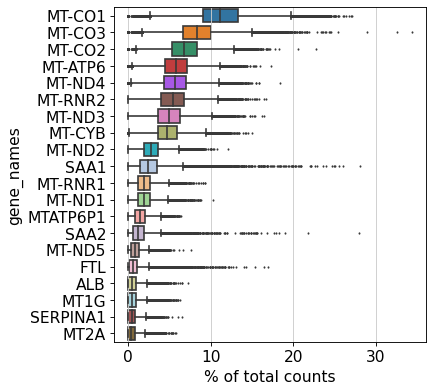

In [17]:
# Show highest genes
sc.pl.highest_expr_genes(adata, n_top=20, )


Next, we can filter for lowly expressed genes using the `pp.filter_cells()` and the `pp.filter_genes()` functions. These will filter out any genes that have less than 1 UMI and are expressed in less than 3 cells.

In [18]:
# Filter cells and genes; filters genes that are detected in less than 3 cells

sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 34968 genes that are detected in less than 3 cells


We can also filter out cells that express a high level of mitochondrial genes, an indication of poor cell quality. To find mitochondrial genes, we look for gene names that start with `MT-` and mark them in a new `mt` field. 

Then, we calculate common QC metrics, such as `n_genes_by_counts`, `total_counts` and `pct_counts_mt`, which we can visualize ina violin plot.

In [19]:
#Can caluclate mitochondrial genes 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'input_id' as categorical
... storing 'Gene' as categorical


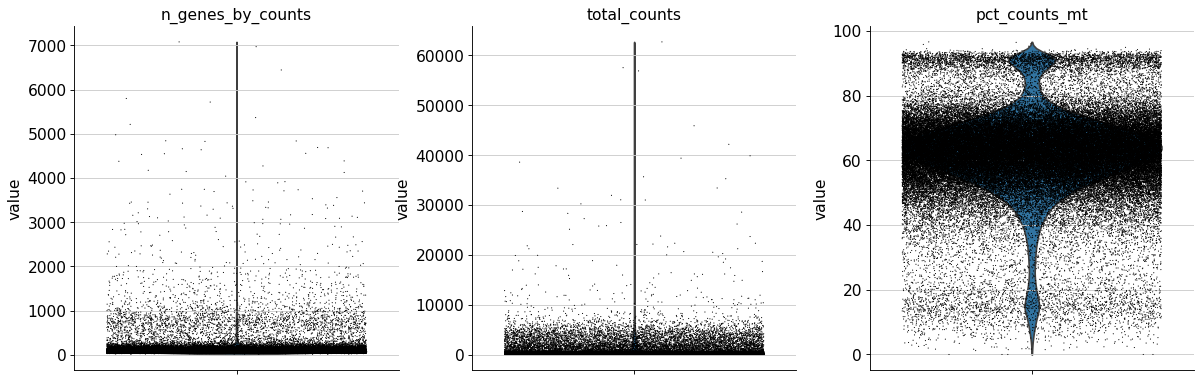

In [20]:
# Violin plots for qc measures 
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

While the Scanpy tutorial shows how to generate these common QC metrics, it's worth noting that the Optimus pipeline already generates several useful metrics. 

Below, we can explore Optimus metrics using Violin plots.

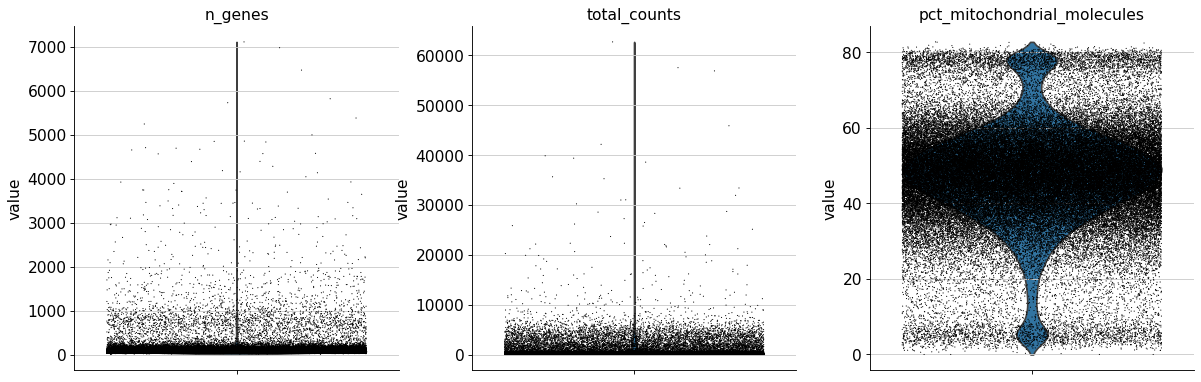

In [21]:
# Violin plots using the precalculated metrics
# Violin plots for qc measures 
sc.pl.violin(adata, ['n_genes', 'total_counts', 'pct_mitochondrial_molecules'],
             jitter=0.4, multi_panel=True)

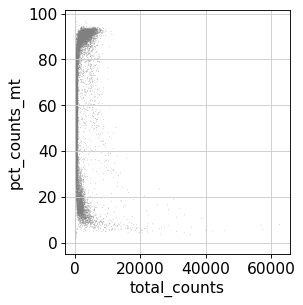

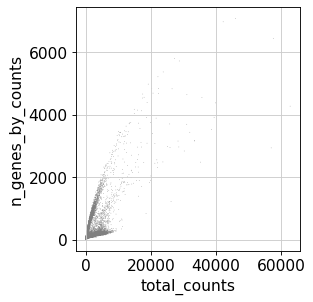

In [22]:
# Remove cells with too many mitochondrial genes or total counts- check the graph first
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

After visualizing the metrics, we can do the actually filtering by slicing the AnnData object. Below, we specifically filter any cells that have genes with less than 2500 expressed genes and less than 10 percent mitochondrial genes.

In [23]:
# Remove cells by slicing the AnnData
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 10, :]

## Normalizing the data
Scanpy uses the `pp.normalize_total()` function to correct for library size and the `pp.log1p()` function to log-scale the data, both common pre-clustering steps.

In [24]:
# Normalize- library size correct
sc.pp.normalize_total(adata, target_sum=1e4)

/home/jupyter-user/notebooks/packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


In [25]:
#log-scale the data
sc.pp.log1p(adata)


## Performing feature selection
Identifying genes and other features that are highly variable from cell-to-cell can help highlight biological signal.

Scanpy uses the `pp.highly_variable_genes()` function to identify highly variable genes which we can vidualize in a plot and filter on. We'll save this in a new AnnData object called `adata.raw`. 

After filtering, we'll regress out the effects of the mitochondrial genes and total counts. Then we'll scale each gene to unit variance. 



In [26]:
#Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


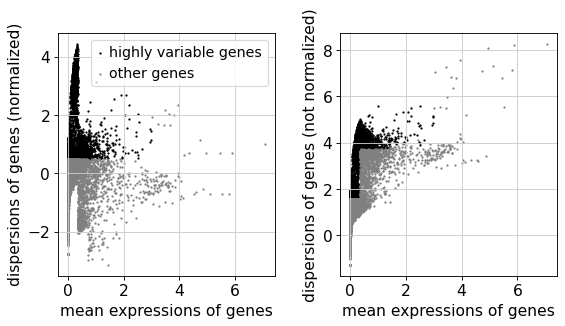

In [27]:
#Plot highly variable genes
sc.pl.highly_variable_genes(adata)

In [28]:
#Freeze the Adata object
adata.raw = adata

In [29]:
#Filter the object by highly variable genes?
adata = adata[:, adata.var.highly_variable]

In [30]:
# Regress out the effects of mitochondrial genes and total counts
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:07)


In [31]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)


## Performing dimensionality reduction 
Dimentionality reduction allows us to identify factors contributing to data variance. First, we'll perform a principle component analysis (PCA) using the `tl.pca()` function. 

We can then create a scatter plot using the `pl.pca()` function, specifying one gene, such as "CST3."

In [32]:
# Reduce dimensionality
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


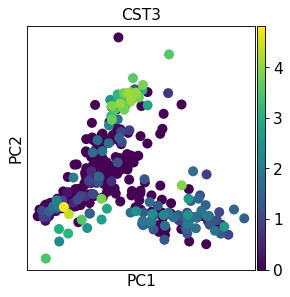

In [33]:
# Plot
sc.pl.pca(adata, color='CST3')


Next, we want to identify the top principle components that contribute to the majority of the variation. Scanpy specifically uses the `pl.pca_variance_ratio()` function, which creates a scree plot (or elbow plot). 

We can use the elbow of the scree plot to determine a cut-off point for the principle components. 

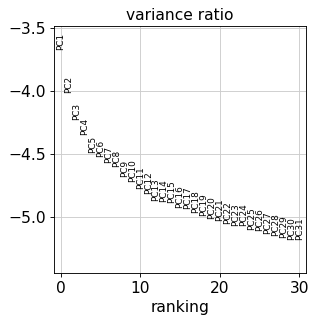

In [34]:
# Use scree to determine how many PCs to use
sc.pl.pca_variance_ratio(adata, log=True)

In [35]:
# Save the result- can't get to work
adata.write(results_file)

In [36]:
adata


AnnData object with n_obs × n_vars = 370 × 3037
    obs: 'antisense_reads', 'cell_barcode_fraction_bases_above_30_mean', 'cell_barcode_fraction_bases_above_30_variance', 'cell_names', 'duplicate_reads', 'emptydrops_FDR', 'emptydrops_IsCell', 'emptydrops_Limited', 'emptydrops_LogProb', 'emptydrops_PValue', 'emptydrops_Total', 'fragments_per_molecule', 'fragments_with_single_read_evidence', 'genes_detected_multiple_observations', 'genomic_read_quality_mean', 'genomic_read_quality_variance', 'genomic_reads_fraction_bases_quality_above_30_mean', 'genomic_reads_fraction_bases_quality_above_30_variance', 'input_id', 'molecule_barcode_fraction_bases_above_30_mean', 'molecule_barcode_fraction_bases_above_30_variance', 'molecules_with_single_read_evidence', 'n_fragments', 'n_genes', 'n_mitochondrial_genes', 'n_mitochondrial_molecules', 'n_molecules', 'n_reads', 'noise_reads', 'pct_mitochondrial_molecules', 'perfect_cell_barcodes', 'perfect_molecule_barcodes', 'reads_mapped_exonic', 'reads_mappe

Notice the results are saved in the field PCs.

## Performing non-linear demensionality reduction (UMAP)
We'll calculate a neighborhood graph and then embed that graph in a UMAP representation.

In [37]:
#Calculate neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [38]:
# Embed in UMAP
#tl.paga(adata)
#pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
#tl.umap(adata, init_pos='paga')

In [39]:
# Embed in UMAP
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


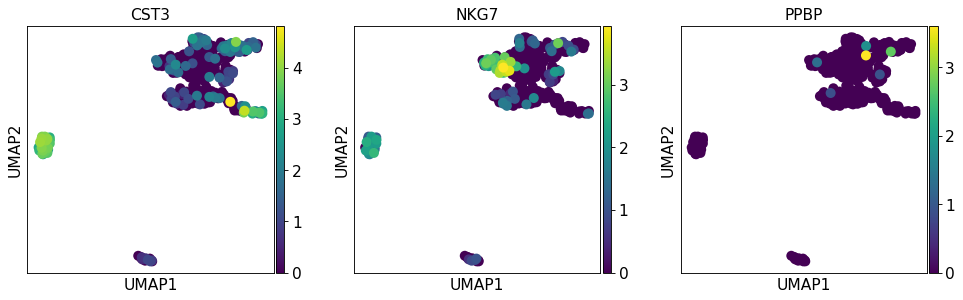

In [40]:
# Plot the scaled gene expression in UMAP
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=True)

## Clustering
Scanpy recommends the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://arxiv.org/abs/1810.08473). 

Leiden clustering directly clusters the neighborhood graph of cells that we computed above. We can visualize the Leiden clusters on the UMAP.

In [41]:
!pip3 install leidenalg
import leidenalg
sc.tl.leiden(adata)

     |████████████████████████████████| 1.4 MB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 16.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


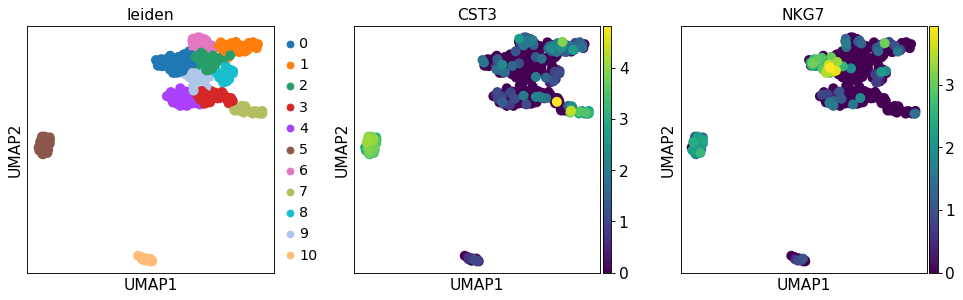

In [42]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [43]:
# Save the result
adata.write(results_file)

## Differential Expression Testing
We'll use the `tl.rank_genes_groups()` function to perform a t-test on the clusters to identify markers genes for each cluster.


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


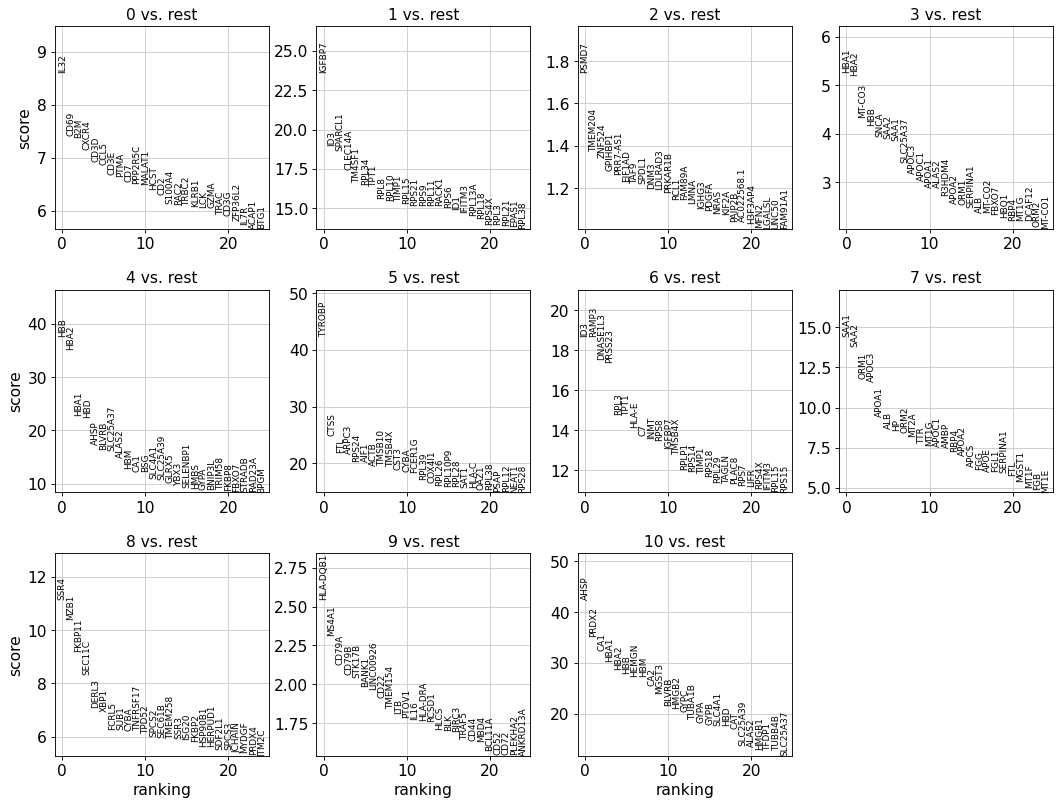

In [44]:
# Find Marker Genes
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [45]:
# Save the result
adata.write(results_file)

We can examine the top 10 ranked genes for each cluster.

In [46]:
# Data frame with top 10 genes per cluster
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,IL32,IGFBP7,PSMD7,HBA1,HBB,TYROBP,ID3,SAA1,SSR4,HLA-DQB1,AHSP
1,CD69,ID3,TMEM204,HBA2,HBA2,CTSS,RAMP3,SAA2,MZB1,MS4A1,PRDX2
2,B2M,SPARCL1,ZNF524,MT-CO3,HBA1,FTL,DNASE1L3,ORM1,FKBP11,CD79A,CA1
3,CXCR4,CLEC14A,GPIHBP1,HBB,HBD,ARPC3,PRSS23,APOC3,SEC11C,CD79B,HBA1
4,CD3D,TM4SF1,PRR7-AS1,SNCA,AHSP,RPS24,RPL3,APOA1,DERL3,STK17B,HBA2


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


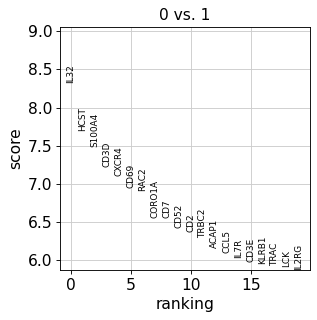

In [47]:
# Look at individual clusters
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='t-test')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

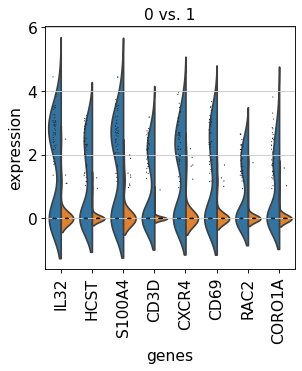

In [48]:
# Plot Violin for top genes in specific cluster
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)


In [49]:
# read in results file
adata = sc.read(results_file)

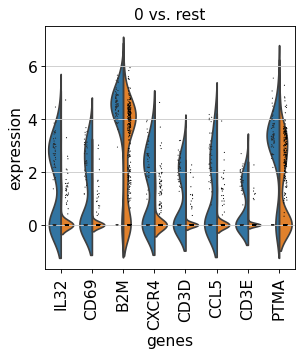

In [50]:
# plot Violin for one cluster vs. all clusters
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

## Copying output files to Workspace Google Bucket

Data generated by running an analysis in a Jupyter Notebook is saved to the disk associated with the Cloud Environment. When the disk is deleted, the data are as well.

You can backup your work by moving files to your workspace Google Bucket.

Remember those system environment variables set up at the beginning of this Notebook? The code below uses those variables to simplify copying files to the workspace.

In [51]:
!gsutil cp ./*.h5ad $bucket
!gsutil ls $bucket

Copying file://./liver_project.h5ad [Content-Type=application/octet-stream]...
- [1 files][ 34.9 MiB/ 34.9 MiB]                                                
Operation completed over 1 objects/34.9 MiB.                                     
gs://fc-72a499d9-46c1-46fe-9b08-9ee4d9196649/liver_project.h5ad
gs://fc-72a499d9-46c1-46fe-9b08-9ee4d9196649/29bb67a2-aa32-48ac-8584-82873fd51b44/
gs://fc-72a499d9-46c1-46fe-9b08-9ee4d9196649/Cumulus/
gs://fc-72a499d9-46c1-46fe-9b08-9ee4d9196649/notebooks/


## Congrats! You've successfully completed the single-cell analysis of HCA data with Scanpy.

If you want more information on how to annotate clusters, check out the original [Scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html#Preprocessing).

For questions or feedback on this workspace, please post in the [Featured Workspace Community Forum](https://support.terra.bio/hc/en-us/community/topics/360001603491).